## 1. Environment Setup

In [1]:
# Environment setup
from pathlib import Path
from typing import Optional
import sys

try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except Exception:
    DOTENV_AVAILABLE = False

# Helper to find project root
def _find_root(start: Optional[Path] = None) -> Path:
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Resolve project directories consistently
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
PROCESSED_DIR = DATA_DIR / 'processed'
ECONOMIC_DIR = DATA_DIR / 'economic_data'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
for d in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, ECONOMIC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"🎯 Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   ECONOMIC_DIR: {ECONOMIC_DIR}")

🎯 Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   ECONOMIC_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data


## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Load Budget Data Files

נטען את נתוני התקציבים שנאספו ממקורות שונים:
- **תקציב כולל של הליגה** (2008-2022) - ממקורות תקשורת שונים
- **תקציבי קבוצות ספציפיים** (2021-2025) - מ-Sport5 ומקורות אחרים  
- **הערכות Gemini AI** (2006-2024) - משוערך על בסיס טבלאות מהתקשורת

**⚠️ חשוב לזכור**: מדובר בנתונים משוערים שנאספו ממקורות שונים ויש להתייחס אליהם בזהירות.

In [3]:
# Load the three budget data files
budget_files = {
    'total_league': ECONOMIC_DIR / 'ligat_haal_total_budgets_mixed.csv',
    'club_budgets_2021_2025': ECONOMIC_DIR / 'ligat_haal_budgets_2021_2025.csv',
    'gemini_estimates': ECONOMIC_DIR / 'gemini_budget_estimates_2006_2024.csv'
}

# Read the files
try:
    # 1. Total league budgets (aggregate data)
    df_total_league = pd.read_csv(budget_files['total_league'])
    print(f"✅ Loaded total league budgets: {len(df_total_league)} records")
    
    # 2. Club-specific budgets 2021-2025
    df_club_budgets = pd.read_csv(budget_files['club_budgets_2021_2025'])
    print(f"✅ Loaded club budgets (2021-2025): {len(df_club_budgets)} records")
    
    # 3. Gemini AI estimates 2006-2024
    df_gemini = pd.read_csv(budget_files['gemini_estimates'])
    print(f"✅ Loaded Gemini estimates (2006-2024): {len(df_gemini)} records")
    
    print("\n📊 Data loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading files: {e}")

✅ Loaded total league budgets: 14 records
✅ Loaded club budgets (2021-2025): 56 records
✅ Loaded Gemini estimates (2006-2024): 90 records

📊 Data loaded successfully!


## 4. Explore Budget Data Structure

In [4]:
print("=" * 80)
print("1️⃣ TOTAL LEAGUE BUDGETS (Aggregate)")
print("=" * 80)
print(f"\nColumns: {list(df_total_league.columns)}")
print(f"Date range: {df_total_league['season'].min()} to {df_total_league['season'].max()}")
print(f"\nSample data:")
display(df_total_league.head())

print("\n" + "=" * 80)
print("2️⃣ CLUB BUDGETS 2021-2025 (Specific Teams)")
print("=" * 80)
print(f"\nColumns: {list(df_club_budgets.columns)}")
print(f"Seasons: {sorted(df_club_budgets['season'].unique())}")
print(f"Number of teams per season:")
display(df_club_budgets.groupby('season')['team_english'].count().to_frame('Teams'))
print(f"\nSample data (2024/25):")
display(df_club_budgets[df_club_budgets['season'] == '2024/25'].head(10))

print("\n" + "=" * 80)
print("3️⃣ GEMINI AI ESTIMATES 2006-2024")
print("=" * 80)
print(f"\nColumns: {list(df_gemini.columns)}")
print(f"Date range: {df_gemini['season'].min()} to {df_gemini['season'].max()}")
print(f"Unique teams: {df_gemini['team_english'].nunique()}")
print(f"\nNote: Includes 'Rest of league' category for smaller clubs")
print(f"\nSample data:")
display(df_gemini.head(10))

1️⃣ TOTAL LEAGUE BUDGETS (Aggregate)

Columns: ['season', 'total_league_budget_million_nis', 'source_note']
Date range: 2006/07 to 2024/25

Sample data:


,season,total_league_budget_million_nis,source_note
0,2008/09,475.3,Calcalist total league budgets (approx)
1,2009/10,405.8,Average of 412.4 (Calcalist) and 399.2 (Globes)
2,2010/11,464.0,Calcalist/Globes total league budgets (approx)
3,2011/12,422.8,Average of 451.6 (Calcalist) and 394 (Globes)
4,2012/13,423.0,Globes total league budgets



2️⃣ CLUB BUDGETS 2021-2025 (Specific Teams)

Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis']
Seasons: ['2021/22', '2022/23', '2023/24', '2024/25']
Number of teams per season:


,Teams
season,
2021/22,14
2022/23,14
2023/24,14
2024/25,14



Sample data (2024/25):


,season,team_english,team_hebrew,budget_min_million_nis,budget_max_million_nis,source_note,budget_mid_million_nis
0,2024/25,Maccabi Tel Aviv,"מכבי ת""א",120.0,120.0,Sport5 'ליגת הכסף' 24.8.2024,120.0
1,2024/25,Maccabi Haifa,מכבי חיפה,105.0,110.0,Range 105–110; Sport5,107.5
2,2024/25,Hapoel Be'er Sheva,"הפועל ב""ש",70.0,70.0,Sport5,70.0
3,2024/25,Beitar Jerusalem,"בית""ר ירושלים",51.0,51.0,Includes past debts; Sport5,51.0
4,2024/25,Hapoel Jerusalem,הפועל ירושלים,33.0,33.0,Includes women & youth; Sport5,33.0
5,2024/25,Maccabi Netanya,מכבי נתניה,31.0,31.0,Sport5,31.0
6,2024/25,Hapoel Haifa,הפועל חיפה,29.0,29.0,Includes youth department; Sport5,29.0
7,2024/25,Maccabi Petah Tikva,"מכבי פ""ת",26.0,26.0,Includes youth department; Sport5,26.0
8,2024/25,Hapoel Hadera,הפועל חדרה,22.0,22.0,Sport5,22.0
9,2024/25,Bnei Sakhnin,בני סכנין,20.5,20.5,Sport5,20.5



3️⃣ GEMINI AI ESTIMATES 2006-2024

Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis']
Date range: 2006/07 to 2023/24
Unique teams: 7

Note: Includes 'Rest of league' category for smaller clubs

Sample data:


,season,team_english,team_hebrew,budget_min_million_nis,budget_max_million_nis,source_note,budget_mid_million_nis
0,2006/07,Beitar Jerusalem,"בית""ר ירושלים",120.0,150.0,Gemini AI estimated range from media-based tab...,135.0
1,2006/07,Maccabi Haifa,מכבי חיפה,40.0,60.0,Gemini AI estimated range from media-based tab...,50.0
2,2006/07,Maccabi Tel Aviv,מכבי תל אביב,30.0,50.0,Gemini AI estimated range from media-based tab...,40.0
3,2006/07,Hapoel Tel Aviv,הפועל תל אביב,25.0,40.0,Gemini AI estimated range from media-based tab...,32.5
4,2006/07,Rest of league,שאר הליגה,5.0,20.0,Gemini AI estimated range from media-based tab...,12.5
5,2007/08,Beitar Jerusalem,"בית""ר ירושלים",120.0,150.0,Gemini AI estimated range from media-based tab...,135.0
6,2007/08,Maccabi Haifa,מכבי חיפה,40.0,60.0,Gemini AI estimated range from media-based tab...,50.0
7,2007/08,Maccabi Tel Aviv,מכבי תל אביב,30.0,50.0,Gemini AI estimated range from media-based tab...,40.0
8,2007/08,Hapoel Tel Aviv,הפועל תל אביב,25.0,40.0,Gemini AI estimated range from media-based tab...,32.5
9,2007/08,Rest of league,שאר הליגה,5.0,20.0,Gemini AI estimated range from media-based tab...,12.5


## 5. Create Combined Budget Dataset

נשלב את כל מקורות הנתונים לטבלה אחת מאוחדת עם אינדיקציה למקור המידע.

In [5]:
# Combine club-specific budgets (2021-2025 + Gemini estimates)
# Add source indicator
df_club_budgets['data_source'] = 'Sport5/Media (2021-2025)'
df_gemini['data_source'] = 'Gemini AI Estimate (2006-2024)'

# Combine the two club-level datasets
df_all_budgets = pd.concat([df_gemini, df_club_budgets], ignore_index=True)

# Sort by season and budget
df_all_budgets = df_all_budgets.sort_values(['season', 'budget_mid_million_nis'], ascending=[True, False])

print(f"✅ Combined budget dataset created!")
print(f"   Total records: {len(df_all_budgets)}")
print(f"   Date range: {df_all_budgets['season'].min()} to {df_all_budgets['season'].max()}")
print(f"   Unique teams: {df_all_budgets['team_english'].nunique()}")
print(f"\nData sources breakdown:")
display(df_all_budgets['data_source'].value_counts().to_frame('Count'))

print("\n" + "=" * 80)
print("Sample - Top budgets by season:")
display(df_all_budgets.groupby('season').head(3)[['season', 'team_english', 'budget_mid_million_nis', 'data_source']])

✅ Combined budget dataset created!
   Total records: 146
   Date range: 2006/07 to 2024/25
   Unique teams: 21

Data sources breakdown:


,Count
data_source,
Gemini AI Estimate (2006-2024),90
Sport5/Media (2021-2025),56



Sample - Top budgets by season:


,season,team_english,budget_mid_million_nis,data_source
0,2006/07,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
1,2006/07,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
2,2006/07,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
5,2007/08,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
6,2007/08,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
7,2007/08,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
10,2008/09,Beitar Jerusalem,110.0,Gemini AI Estimate (2006-2024)
14,2008/09,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
12,2008/09,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
13,2009/10,Maccabi Tel Aviv,87.5,Gemini AI Estimate (2006-2024)


## 6. Budget Analysis - Key Metrics

In [6]:
# Calculate key budget metrics by season
budget_metrics = df_all_budgets.groupby('season').agg({
    'budget_mid_million_nis': ['sum', 'mean', 'max', 'min', 'std'],
    'team_english': 'count'
}).round(2)

budget_metrics.columns = ['Total_Budget_NIS_m', 'Avg_Budget_NIS_m', 'Max_Budget_NIS_m', 
                          'Min_Budget_NIS_m', 'Std_Budget_NIS_m', 'Num_Teams']

# Calculate inequality metrics
budget_metrics['Budget_Ratio_Max_Min'] = (budget_metrics['Max_Budget_NIS_m'] / 
                                           budget_metrics['Min_Budget_NIS_m']).round(2)

budget_metrics['Budget_Gini_Approx'] = (budget_metrics['Std_Budget_NIS_m'] / 
                                         budget_metrics['Avg_Budget_NIS_m']).round(3)

print("📊 Budget Metrics by Season")
print("=" * 80)
display(budget_metrics)

print("\n" + "=" * 80)
print("Key Insights:")
print(f"   💰 Highest total league budget: {budget_metrics['Total_Budget_NIS_m'].max():.0f}M NIS in {budget_metrics['Total_Budget_NIS_m'].idxmax()}")
print(f"   📈 Biggest budget disparity (max/min ratio): {budget_metrics['Budget_Ratio_Max_Min'].max():.1f}x in {budget_metrics['Budget_Ratio_Max_Min'].idxmax()}")
print(f"   📉 Smallest budget disparity: {budget_metrics['Budget_Ratio_Max_Min'].min():.1f}x in {budget_metrics['Budget_Ratio_Max_Min'].idxmin()}")

📊 Budget Metrics by Season


,Total_Budget_NIS_m,Avg_Budget_NIS_m,Max_Budget_NIS_m,Min_Budget_NIS_m,Std_Budget_NIS_m,Num_Teams,Budget_Ratio_Max_Min,Budget_Gini_Approx
season,,,,,,,,
2006/07,270.0,54.00,135.0,12.5,47.32,5,10.80,0.876
2007/08,270.0,54.00,135.0,12.5,47.32,5,10.80,0.876
2008/09,245.0,49.00,110.0,12.5,36.77,5,8.80,0.750
2009/10,221.5,44.30,87.5,11.5,27.98,5,7.61,0.632
2010/11,260.0,52.00,105.0,12.5,34.70,5,8.40,0.667
2011/12,242.0,48.40,88.0,11.5,29.14,5,7.65,0.602
2012/13,270.0,54.00,105.0,22.5,32.62,5,4.67,0.604
2013/14,285.0,57.00,130.0,27.5,42.11,5,4.73,0.739
2014/15,315.5,63.10,125.0,32.5,40.54,5,3.85,0.642



Key Insights:
   💰 Highest total league budget: 893M NIS in 2023/24
   📈 Biggest budget disparity (max/min ratio): 10.9x in 2016/17
   📉 Smallest budget disparity: 3.9x in 2014/15


## 7. Top Budget Teams Over Time

In [7]:
# Identify top budget teams per season
top_budget_teams = df_all_budgets.loc[df_all_budgets.groupby('season')['budget_mid_million_nis'].idxmax()]

print("🏆 Team with Highest Budget Each Season")
print("=" * 80)
display(top_budget_teams[['season', 'team_english', 'budget_mid_million_nis', 'data_source']].sort_values('season'))

# Count how many times each team had the highest budget
print("\n" + "=" * 80)
print("📊 Frequency of Highest Budget by Team:")
top_team_counts = top_budget_teams['team_english'].value_counts()
display(top_team_counts.to_frame('Times as Top Budget'))

# Get top 3 budgets for recent seasons
print("\n" + "=" * 80)
print("💰 Top 3 Budgets in Recent Seasons (2021-2025):")
recent_top3 = (df_all_budgets[df_all_budgets['season'].str.startswith(('2021', '2022', '2023', '2024'))]
               .groupby('season')
               .apply(lambda x: x.nlargest(3, 'budget_mid_million_nis')[['team_english', 'budget_mid_million_nis']])
               .reset_index(level=1, drop=True))
display(recent_top3)

🏆 Team with Highest Budget Each Season


,season,team_english,budget_mid_million_nis,data_source
0,2006/07,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
5,2007/08,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
10,2008/09,Beitar Jerusalem,110.0,Gemini AI Estimate (2006-2024)
13,2009/10,Maccabi Tel Aviv,87.5,Gemini AI Estimate (2006-2024)
20,2010/11,Maccabi Tel Aviv,105.0,Gemini AI Estimate (2006-2024)
21,2011/12,Maccabi Tel Aviv,88.0,Gemini AI Estimate (2006-2024)
30,2012/13,Maccabi Tel Aviv,105.0,Gemini AI Estimate (2006-2024)
31,2013/14,Maccabi Tel Aviv,130.0,Gemini AI Estimate (2006-2024)
40,2014/15,Maccabi Tel Aviv,125.0,Gemini AI Estimate (2006-2024)
41,2015/16,Maccabi Tel Aviv,163.0,Gemini AI Estimate (2006-2024)



📊 Frequency of Highest Budget by Team:


,Times as Top Budget
team_english,
Maccabi Tel Aviv,16
Beitar Jerusalem,3



💰 Top 3 Budgets in Recent Seasons (2021-2025):


,team_english,budget_mid_million_nis
season,,
2021/22,Maccabi Tel Aviv,110.0
2021/22,Maccabi Haifa,110.0
2021/22,Maccabi Tel Aviv,100.0
2022/23,Maccabi Tel Aviv,112.5
2022/23,Maccabi Tel Aviv,110.0
2022/23,Maccabi Haifa,105.0
2023/24,Maccabi Tel Aviv,120.0
2023/24,Maccabi Haifa,105.0
2023/24,Maccabi Tel Aviv,105.0


## 8. Budget Visualizations

✅ Budget visualization saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\budget_analysis_overview.png


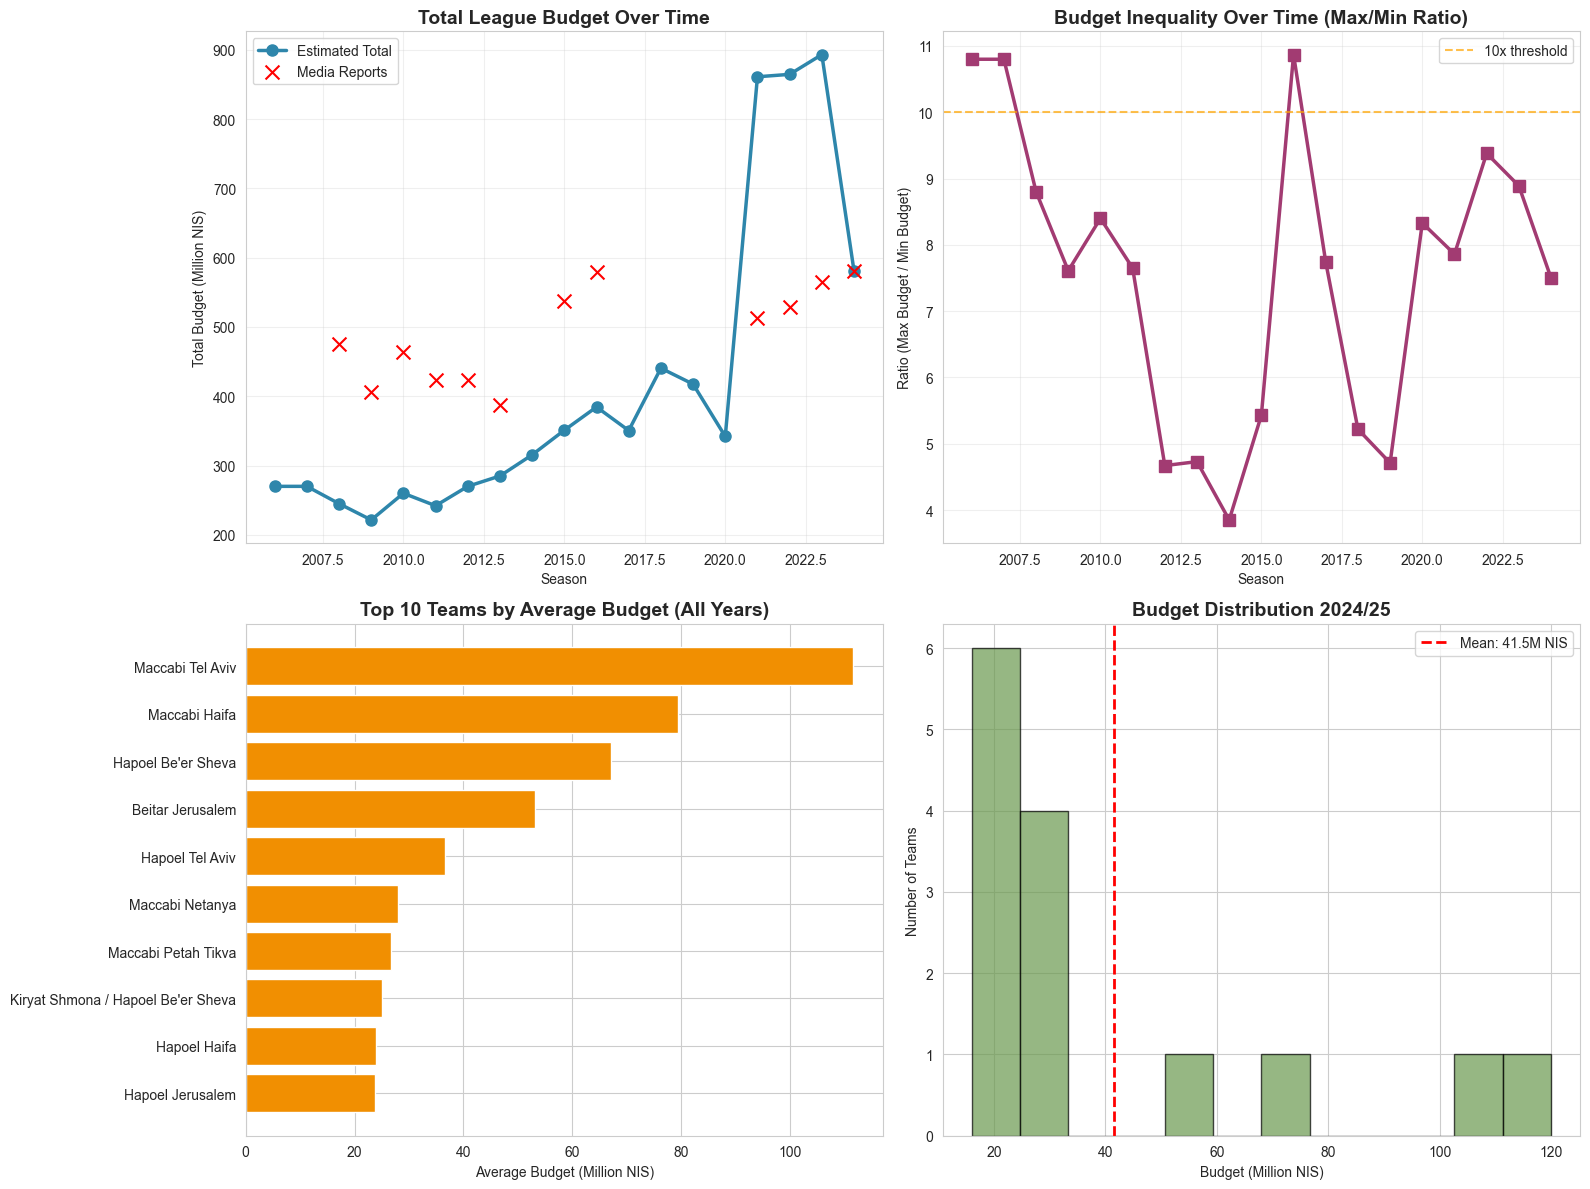

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
budget_metrics_sorted = budget_metrics.sort_index()
budget_metrics_sorted['season_year'] = budget_metrics_sorted.index.str[:4].astype(int)

# 1. Total league budget over time
axes[0, 0].plot(budget_metrics_sorted['season_year'], budget_metrics_sorted['Total_Budget_NIS_m'], 
                marker='o', linewidth=2.5, markersize=8, color='#2E86AB', label='Estimated Total')
axes[0, 0].set_title('Total League Budget Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Total Budget (Million NIS)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add comparison with total_league data
if not df_total_league.empty:
    df_total_league_sorted = df_total_league.copy()
    df_total_league_sorted['season_year'] = df_total_league_sorted['season'].str[:4].astype(int)
    axes[0, 0].scatter(df_total_league_sorted['season_year'], 
                       df_total_league_sorted['total_league_budget_million_nis'],
                       marker='x', s=100, color='red', label='Media Reports', zorder=5)
    axes[0, 0].legend()

# 2. Budget inequality (Max/Min ratio)
axes[0, 1].plot(budget_metrics_sorted['season_year'], budget_metrics_sorted['Budget_Ratio_Max_Min'], 
                marker='s', linewidth=2.5, markersize=8, color='#A23B72')
axes[0, 1].set_title('Budget Inequality Over Time (Max/Min Ratio)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Ratio (Max Budget / Min Budget)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='10x threshold')
axes[0, 1].legend()

# 3. Top 5 teams - average budget
top_teams = df_all_budgets.groupby('team_english')['budget_mid_million_nis'].mean().nlargest(10)
axes[1, 0].barh(range(len(top_teams)), top_teams.values, color='#F18F01')
axes[1, 0].set_yticks(range(len(top_teams)))
axes[1, 0].set_yticklabels(top_teams.index)
axes[1, 0].set_title('Top 10 Teams by Average Budget (All Years)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Budget (Million NIS)')
axes[1, 0].invert_yaxis()

# 4. Budget distribution in 2024/25
if '2024/25' in df_all_budgets['season'].values:
    latest_budgets = df_all_budgets[df_all_budgets['season'] == '2024/25']['budget_mid_million_nis']
    axes[1, 1].hist(latest_budgets, bins=12, color='#6A994E', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Budget Distribution 2024/25', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Budget (Million NIS)')
    axes[1, 1].set_ylabel('Number of Teams')
    axes[1, 1].axvline(latest_budgets.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {latest_budgets.mean():.1f}M NIS')
    axes[1, 1].legend()

plt.tight_layout()

# Save figure
fig_path_budgets = FIG_DIR / 'budget_analysis_overview.png'
plt.savefig(fig_path_budgets, dpi=300, bbox_inches='tight')
print(f"✅ Budget visualization saved: {fig_path_budgets}")

plt.show()

## 9. Save Combined Budget Data

In [9]:
# Save the combined budget dataset
combined_budget_file = ECONOMIC_DIR / 'budget_data_combined_all_sources.csv'
df_all_budgets.to_csv(combined_budget_file, index=False, encoding='utf-8-sig')
print(f"✅ Saved combined budget data: {combined_budget_file}")
print(f"   Records: {len(df_all_budgets)}")
print(f"   Columns: {list(df_all_budgets.columns)}")

# Save the metrics summary
metrics_file = ECONOMIC_DIR / 'budget_metrics_by_season.csv'
budget_metrics.to_csv(metrics_file, encoding='utf-8-sig')
print(f"\n✅ Saved budget metrics: {metrics_file}")

# Save total league budgets separately
total_league_file = ECONOMIC_DIR / 'total_league_budgets_summary.csv'
df_total_league.to_csv(total_league_file, index=False, encoding='utf-8-sig')
print(f"✅ Saved total league budgets: {total_league_file}")

print("\n🎉 All budget data files saved successfully!")

✅ Saved combined budget data: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\budget_data_combined_all_sources.csv
   Records: 146
   Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis', 'data_source']

✅ Saved budget metrics: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\budget_metrics_by_season.csv
✅ Saved total league budgets: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\total_league_budgets_summary.csv

🎉 All budget data files saved successfully!


---

## סיכום ניתוח תקציבים

### 📊 מקורות המידע:
1. **תקציב כולל של הליגה** (2008-2022) - ממקורות תקשורת: Calcalist, Globes, Sport5, ONE
2. **תקציבי קבוצות ספציפיים** (2021-2025) - Sport5 ומקורות מדיה אחרים
3. **הערכות Gemini AI** (2006-2024) - משוערך מטבלאות תקשורתיות

### 💡 מדדים שחושבו:
- **פערי תקציבים** - יחס בין התקציב הגבוה לנמוך ביותר
- **אי-שוויון תקציבי** - מקדם Gini משוערך (סטיית תקן / ממוצע)
- **מגמות לאורך זמן** - שינויים בתקציב הכולל והפערים

### ⚠️ הערות חשובות:
- המידע משוערך ונאסף ממקורות שונים - **יש להתייחס בזהירות**
- יש עונות עם פערי מידע (חסרות עונות מסוימות)
- חלק מהנתונים כוללים "Rest of league" (שאר הקבוצות) כקטגוריה כללית
- תקציבים בש"ח (NIS) ולא באירו

### 📁 קבצים שנוצרו:
- `budget_data_combined_all_sources.csv` - כל הנתונים המאוחדים
- `budget_metrics_by_season.csv` - מדדים לפי עונה
- `total_league_budgets_summary.csv` - תקציבים כוללים של הליגה

## ניתוחים נוספים

1. קשר בין תקציב קבוצה למספר שחקנים זרים


✅ נטען קובץ תקציבים: ligat_haal_budgets_2021_2025.csv | (56, 7)
    season        team_english team_hebrew  budget_min_million_nis  \
0  2024/25    Maccabi Tel Aviv    מכבי ת"א                   120.0   
1  2024/25       Maccabi Haifa   מכבי חיפה                   105.0   
2  2024/25  Hapoel Be'er Sheva   הפועל ב"ש                    70.0   

   budget_max_million_nis                   source_note  \
0                   120.0  Sport5 'ליגת הכסף' 24.8.2024   
1                   110.0         Range 105–110; Sport5   
2                    70.0                        Sport5   

   budget_mid_million_nis  
0                   120.0  
1                   107.5  
2                    70.0  
נמצאו 72 קבצים:
- FOREIGN_PLAYERS_2006_07.csv
- FOREIGN_PLAYERS_2007_08.csv
- FOREIGN_PLAYERS_2008_09.csv
- FOREIGN_PLAYERS_2009_10.csv
- FOREIGN_PLAYERS_2010_11.csv
- FOREIGN_PLAYERS_2011_12.csv
- FOREIGN_PLAYERS_2012_13.csv
- FOREIGN_PLAYERS_2013_14.csv
- FOREIGN_PLAYERS_2014_15.csv
- FOREIGN_PLAYERS_20

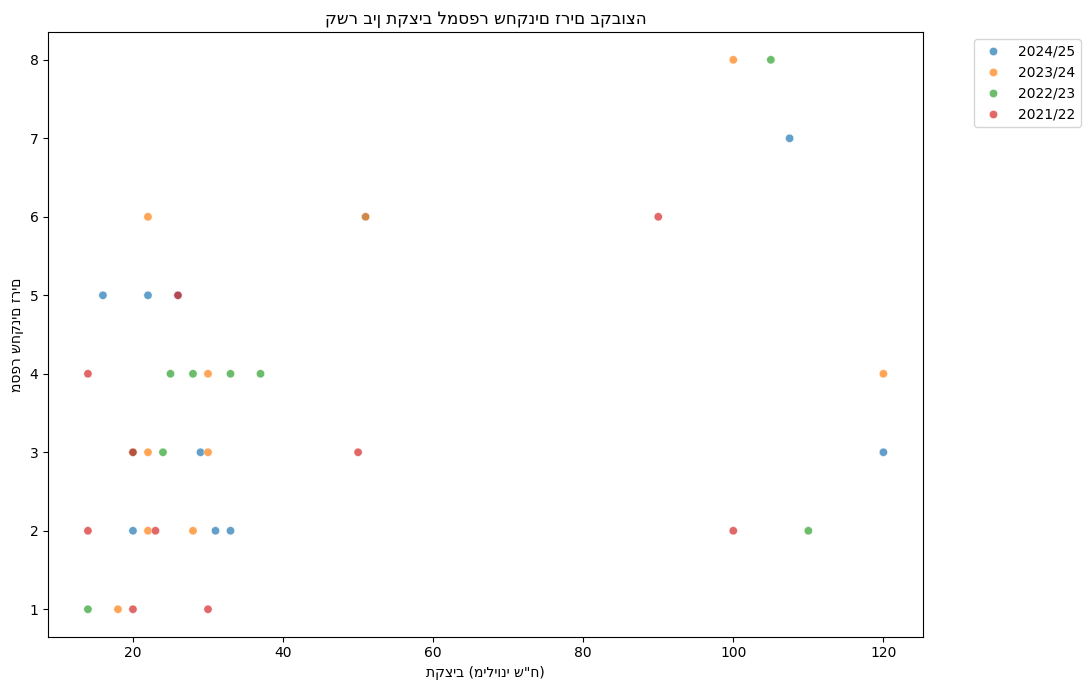

מקדם מתאם (פירסון) לכלל הדאטה: 0.4

מתאם פירסון לפי עונה:
2021/22: 0.29
2022/23: 0.43
2023/24: 0.54
2024/25: 0.28


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 1. טען את טבלת התקציבים של הקבוצות (ligat_haal_budgets_2021_2025.csv)
budget_path = Path(r"C:/Users/idant/Desktop/final project/ligat_haal_project/ligat_haal_project/notebooks/data/economic_data/ligat_haal_budgets_2021_2025.csv")
df_all_budgets = pd.read_csv(budget_path)
print(f"✅ נטען קובץ תקציבים: {budget_path.name} | {df_all_budgets.shape}")
print(df_all_budgets.head(3))

# ודא שעמודות שמות קבוצה ועונה תואמות לשמות בקבצי הזרים
if 'Season' in df_all_budgets.columns:
    df_all_budgets = df_all_budgets.rename(columns={'Season': 'season'})
if 'Team' in df_all_budgets.columns:
    df_all_budgets = df_all_budgets.rename(columns={'Team': 'team_english'})

# 2. איסוף כל קבצי השחקנים הזרים (איתור גמיש)
foreign_dir = Path(r"C:/Users/idant/Desktop/final project/ligat_haal_project/ligat_haal_project/notebooks/data/economic_data")
foreign_files = list(foreign_dir.glob("*FOREIGN*PLAYER*.csv"))
if not foreign_files:
    foreign_files = list(foreign_dir.glob("*foreign*player*.csv"))
print(f"נמצאו {len(foreign_files)} קבצים:")
for f in foreign_files:
    print(f"- {f.name}")

# 3. בניית טבלת מספר שחקנים זרים לכל קבוצה/עונה ישירות לתוך DataFrame אחד
rows = []
for f in foreign_files:
    try:
        print(f"\n--- קורא קובץ: {f.name} ---")
        df = pd.read_csv(f)
        print("עמודות בקובץ:", list(df.columns))
        print("דוגמאות שורות ראשונות:")
        print(df.head(3))
        # נירמול שמות עמודות - רק club/team ל-team_english, לא לגעת ב-season
        if 'club' in df.columns:
            df = df.rename(columns={'club': 'team_english'})
        elif 'team' in df.columns:
            df = df.rename(columns={'team': 'team_english'})
        # אל תיגע ב-'season', אל תיצור כפילויות
        print("עמודות אחרי נירמול:", list(df.columns))
        # בדיקה שהעמודות קיימות
        if {'season', 'team_english'}.issubset(df.columns):
            grouped = df.groupby(['season', 'team_english']).size().reset_index(name='num_foreign_players')
            print("דוגמאות אחרי groupby:")
            print(grouped.head(3))
            for idx, row in grouped.iterrows():
                team_val = str(row['team_english']).strip().lower() if 'team_english' in row else ''
                season_val = str(row['season']).strip() if 'season' in row else ''
                nfp = row['num_foreign_players']
                # הדפסה של כל שורה לפני סינון
                print(f"שורה {idx}: season={season_val}, team={team_val}, num_foreign_players={nfp}")
                if (pd.isna(row['season']) or pd.isna(row['team_english']) or
                    team_val in ['unknown', '2 clubs', '', 'nan', 'none', '0', 'null'] or
                    season_val in ['', 'nan', 'none', '0', 'null']):
                    print(f"-> דילוג על שורה לא תקינה (season/team)")
                    continue
                if pd.isna(nfp) or not str(nfp).isdigit():
                    print(f"-> דילוג על שורה עם num_foreign_players לא תקין: {nfp}")
                    continue
                try:
                    rows.append({
                        'season': season_val,
                        'team_english': str(row['team_english']).strip(),
                        'num_foreign_players': int(nfp)
                    })
                    print(f"-> נוסף בהצלחה!")
                except Exception as e:
                    print(f"שגיאה בהמרה/הוספה: {e}")
        else:
            print(f"קובץ {f.name} לא מכיל את כל העמודות הנדרשות: {df.columns}")
    except Exception as e:
        print(f"בעיה בטעינת קובץ {f}: {e}")

print(f"\nסה\"כ שורות שנאספו: {len(rows)}")

if not rows:
    print('לא נמצאו נתוני שחקנים זרים תקינים! (בדוק שמות עמודות וערכים)')
    for f in foreign_files:
        try:
            df = pd.read_csv(f)
            print(f"\nקובץ: {f.name}")
            print("עמודות:", list(df.columns))
            print(df.head(5))
        except Exception as e:
            print(f"בעיה בטעינת קובץ {f}: {e}")
    raise ValueError("לא נמצאו נתוני שחקנים זרים תקינים!")

foreign_players_df = pd.DataFrame(rows)
print(f"גודל טבלת foreign_players_df: {foreign_players_df.shape}")
if not foreign_players_df.empty:
    print(f"דוגמאות מהטבלה:")
    print(foreign_players_df.head(5))

foreign_players_df = foreign_players_df.drop_duplicates()
foreign_players_df = foreign_players_df.sort_values(['season', 'team_english'])

# 4. חיבור לנתוני התקציב (רק לקבוצות שיש להן עמודת team_english)
if 'team_english' in df_all_budgets.columns:
    df_budget_foreign = pd.merge(df_all_budgets, foreign_players_df, on=['season', 'team_english'], how='left')
    print(f"גודל טבלת df_budget_foreign: {df_budget_foreign.shape}")
else:
    print('לא קיימת עמודת team_english בטבלת התקציבים!')
    print('הקוד ימשיך ללא ניתוח קבוצות לפי תקציב.')
    df_budget_foreign = None

# 5. ניתוחים
if df_budget_foreign is not None:
    print(f"\nסה\"כ רשומות עם נתוני שחקנים זרים: {foreign_players_df.shape[0]}")
    print(f"סה\"כ עונות ייחודיות: {foreign_players_df['season'].nunique()}")
    print(f"סה\"כ קבוצות ייחודיות: {foreign_players_df['team_english'].nunique()}")

    # 6. גרף פיזור
    plt.figure(figsize=(11,7))
    if 'budget_mid_million_nis' in df_budget_foreign.columns:
        sns.scatterplot(data=df_budget_foreign, x='budget_mid_million_nis', y='num_foreign_players', hue='season', alpha=0.7)
        plt.xlabel('תקציב (מיליוני ש"ח)')
    else:
        sns.scatterplot(data=df_budget_foreign, x='season', y='num_foreign_players', hue='season', alpha=0.7)
        plt.xlabel('עונה')
    plt.title('קשר בין תקציב למספר שחקנים זרים בקבוצה')
    plt.ylabel('מספר שחקנים זרים')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 7. מתאם פירסון כולל
    if 'budget_mid_million_nis' in df_budget_foreign.columns and 'num_foreign_players' in df_budget_foreign.columns and df_budget_foreign['num_foreign_players'].notnull().sum() > 0:
        corr = df_budget_foreign[['budget_mid_million_nis', 'num_foreign_players']].corr().iloc[0,1]
        print('מקדם מתאם (פירסון) לכלל הדאטה:', round(corr, 2))
    else:
        print('אין נתונים מספיקים לחישוב מתאם!')

    # 8. מתאם פירסון לפי עונה
    print("\nמתאם פירסון לפי עונה:")
    for season, group in df_budget_foreign.groupby('season'):
        if 'num_foreign_players' in group.columns and group['num_foreign_players'].notnull().sum() > 2:
            c = group[['budget_mid_million_nis', 'num_foreign_players']].corr().iloc[0,1]
            print(f"{season}: {round(c,2)}")
        else:
            print(f"{season}: לא מספיק נתונים")
else:
    print('לא בוצע ניתוח קבוצות לפי תקציב כי אין עמודת team_english בטבלת התקציבים.')

גרף פיזור (Scatter Plot):

כל נקודה מייצגת קבוצה בעונה מסוימת.
ציר X: תקציב הקבוצה (במיליוני ש"ח).
ציר Y: מספר השחקנים הזרים בקבוצה.
הצבעים השונים מייצגים עונות שונות (למשל 2021/22, 2022/23, 2023/24, 2024/25).
המטרה: לראות האם יש מגמה – האם קבוצות עם תקציב גבוה יותר מחזיקות ביותר שחקנים זרים.
הקשר בין תקציב למספר שחקנים זרים:
הניתוח בודק האם קבוצות עם תקציב גבוה יותר נוטות להחזיק יותר שחקנים זרים.

אם המתאם גבוה (למשל 0.5 ומעלה), זה אומר שיש קשר חיובי – קבוצות עשירות מביאות יותר זרים.
אם המתאם נמוך או שלילי, אין קשר מובהק או שיש אפילו מגמה הפוכה.

2. ניתוח נוסף: השפעת שיעור השחקנים הזרים על מיקום הקבוצה בליגה
 
בניתוח זה נבדוק האם יש קשר בין שיעור השחקנים הזרים בסגל של קבוצה לבין המיקום הסופי שלה בליגה (כלומר, האם קבוצות שמסתמכות יותר על זרים מצליחות יותר או פחות).
 
הניתוח יתבצע עבור עונות בהן יש לנו גם נתוני מיקום סופי וגם נתוני שחקנים זרים, ויוצג גרף פיזור עם קו מגמה.

✅ נטענה טבלת אלופות/יורדות: tm_title_race_summary_all_seasons.csv | (20, 6)
    season  leadership_changes   first_leader    last_leader  last_round  \
0  2006/07                   5   H. Kfar Saba   B. Jerusalem          33   
1  2007/08                   0   B. Jerusalem   B. Jerusalem          33   
2  2008/09                   8  Maccabi Haifa  Maccabi Haifa          33   

   distinct_leaders  
0                 4  
1                 1  
2                 3  
עמודות בטבלה: ['season', 'leadership_changes', 'first_leader', 'last_leader', 'last_round', 'distinct_leaders']
Champion: ממוצע זרים = 3.25 (n=20)
Last: ממוצע זרים = 4.00 (n=20)

ממוצע זרים לכלל הליגה (כל העונות): 2.94


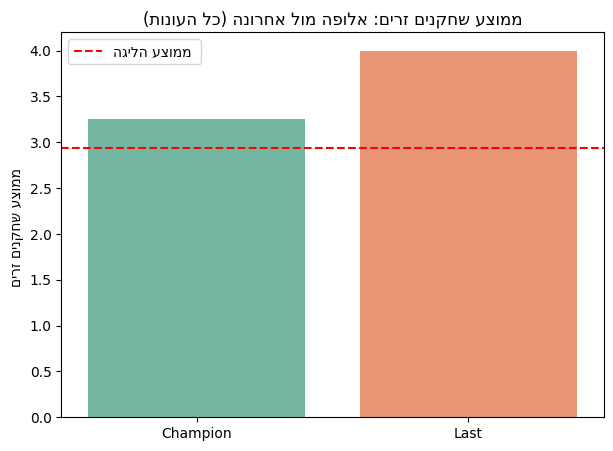


ממוצע זרים לאלופה/אחרונה בכל עונה:
2006/07 - Champion: nan
2006/07 - Last: nan
2007/08 - Champion: nan
2007/08 - Last: nan
2008/09 - Champion: 3.0
2008/09 - Last: 3.0
2009/10 - Champion: nan
2009/10 - Last: 2.0
2010/11 - Champion: 2.0
2010/11 - Last: 2.0
2011/12 - Champion: 2.0
2011/12 - Last: nan
2012/13 - Champion: 2.0
2012/13 - Last: nan
2013/14 - Champion: 2.0
2013/14 - Last: nan
2014/15 - Champion: 2.0
2014/15 - Last: nan
2015/16 - Champion: nan
2015/16 - Last: nan
2016/17 - Champion: nan
2016/17 - Last: nan
2017/18 - Champion: nan
2017/18 - Last: nan
2018/19 - Champion: 6.0
2018/19 - Last: nan
2019/20 - Champion: nan
2019/20 - Last: nan
2020/21 - Champion: nan
2020/21 - Last: 3.0
2021/22 - Champion: nan
2021/22 - Last: 6.0
2022/23 - Champion: nan
2022/23 - Last: 8.0
2023/24 - Champion: nan
2023/24 - Last: nan
2024/25 - Champion: 7.0
2024/25 - Last: nan
2025/26 - Champion: nan
2025/26 - Last: nan


In [29]:
# ניתוח 2: השפעת שיעור השחקנים הזרים על זכייה באליפות ומיקום אחרון
# שימוש בטבלה: tm_title_race_summary_all_seasons.csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# טען את טבלת האלופות והיורדות
summary_path = Path(r"C:/Users/idant/Desktop/final project/ligat_haal_project/ligat_haal_project/notebooks/data/interim/tm_title_race_summary_all_seasons.csv")
df_summary = pd.read_csv(summary_path)
print(f"✅ נטענה טבלת אלופות/יורדות: {summary_path.name} | {df_summary.shape}")
print(df_summary.head(3))

# הדפס את שמות העמודות כדי לוודא
print('עמודות בטבלה:', list(df_summary.columns))

# ודא שמות עמודות תואמות (שימוש באותיות קטנות)
if 'season' not in df_summary.columns or 'first_leader' not in df_summary.columns or 'last_leader' not in df_summary.columns:
    raise ValueError(f"❌ חסרות עמודות נדרשות בטבלה: {df_summary.columns}")

# נבנה טבלה עם כל קבוצה שזכתה באליפות/ירדה, ונחבר אליה את מספר הזרים שלה באותה עונה
champions = df_summary[['season', 'first_leader']].rename(columns={'first_leader': 'team_english'})
champions['status'] = 'Champion'
lasts = df_summary[['season', 'last_leader']].rename(columns={'last_leader': 'team_english'})
lasts['status'] = 'Last'

summary_teams = pd.concat([champions, lasts], ignore_index=True)

# חבר נתוני זרים
summary_teams = pd.merge(summary_teams, foreign_players_df, on=['season', 'team_english'], how='left')

# ניתוח: האם לאלופה יש יותר זרים מהממוצע? ומה עם היורדת?
results = []
for status in ['Champion', 'Last']:
    group = summary_teams[summary_teams['status'] == status]
    avg_foreign = group['num_foreign_players'].mean()
    results.append({'status': status, 'avg_num_foreign_players': avg_foreign, 'count': group.shape[0]})
    print(f"{status}: ממוצע זרים = {avg_foreign:.2f} (n={group.shape[0]})")

# השוואה לכלל הליגה
league_avg = foreign_players_df.groupby('season')['num_foreign_players'].mean().mean()
print(f"\nממוצע זרים לכלל הליגה (כל העונות): {league_avg:.2f}")

# ויזואליזציה
plt.figure(figsize=(7,5))
sns.barplot(x=[r['status'] for r in results], y=[r['avg_num_foreign_players'] for r in results], palette='Set2')
plt.axhline(league_avg, color='red', linestyle='--', label='הגילה עצוממ ')
plt.ylabel('םירז םינקחש עצוממ ')
plt.title("(תונועה לכ) הנורחא לומ הפולא :םירז םינקחש עצוממ"
)
plt.legend()
plt.show()

# טבלה מפורטת לכל עונה
print("\nממוצע זרים לאלופה/אחרונה בכל עונה:")
for season in sorted(df_summary['season'].unique()):
    for status in ['Champion', 'Last']:
        nfp = summary_teams[(summary_teams['season'] == season) & (summary_teams['status'] == status)]['num_foreign_players']
        if not nfp.empty:
            print(f"{season} - {status}: {nfp.values[0]}")
        else:
            print(f"{season} - {status}: אין נתון")

קבוצות שסיימו אחרונות מחזיקות בממוצע יותר שחקנים זרים מהאלופות ומהממוצע בליגה.
אין קשר חיובי בין מספר שחקנים זרים להצלחה – ייתכן שאפילו יש קשר הפוך.
נראה שקבוצות חלשות מסתמכות יותר על זרים, אך זה לא מביא להצלחה.



3. ניתוח שווי שוק גולל של זרים ,האם יש קשר להצלחה בליגה

✅ נטען קובץ סגלים: squad_values_all_seasons_transfermarkt.csv | (280, 8)
    season  season_start_year                 club  squad_size  avg_age  \
0  2006/07               2006     Beitar Jerusalem          30     26.2   
1  2006/07               2006  Maccabi Petah Tikva          38     24.9   
2  2006/07               2006      Hapoel Tel Aviv          33     25.1   

   foreigners  avg_value_millions  total_value_millions  
0           9               0.253                  7.60  
1           8               0.149                  5.65  
2           6               0.147                  4.85  
עמודות: ['season', 'season_start_year', 'club', 'squad_size', 'avg_age', 'foreigners', 'avg_value_millions', 'total_value_millions']


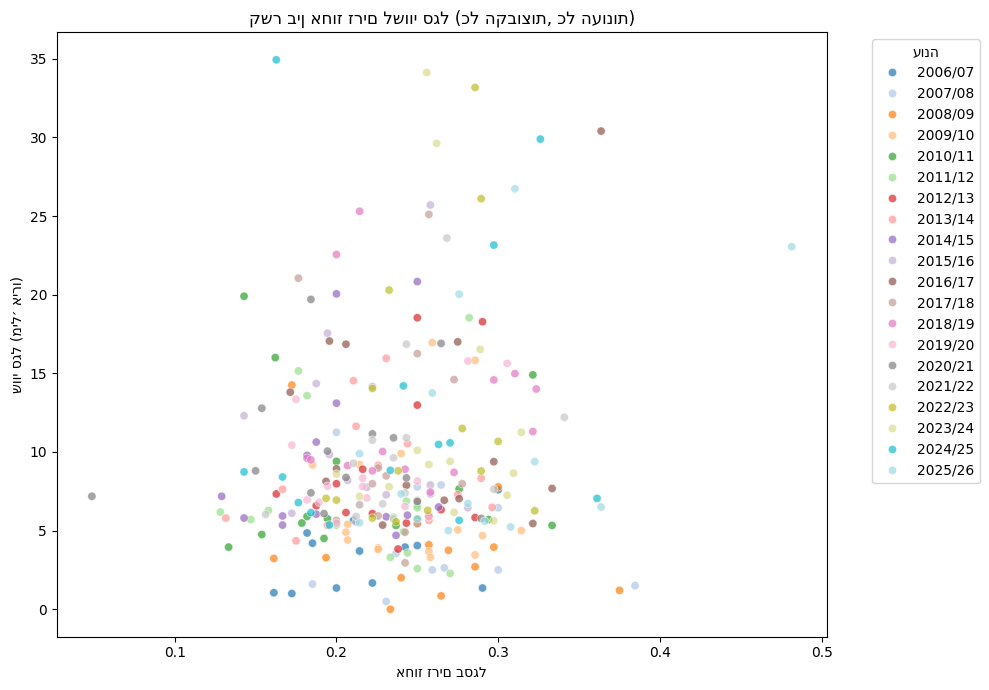


מקדם מתאם פירסון בין אחוז זרים לשווי סגל: 0.13


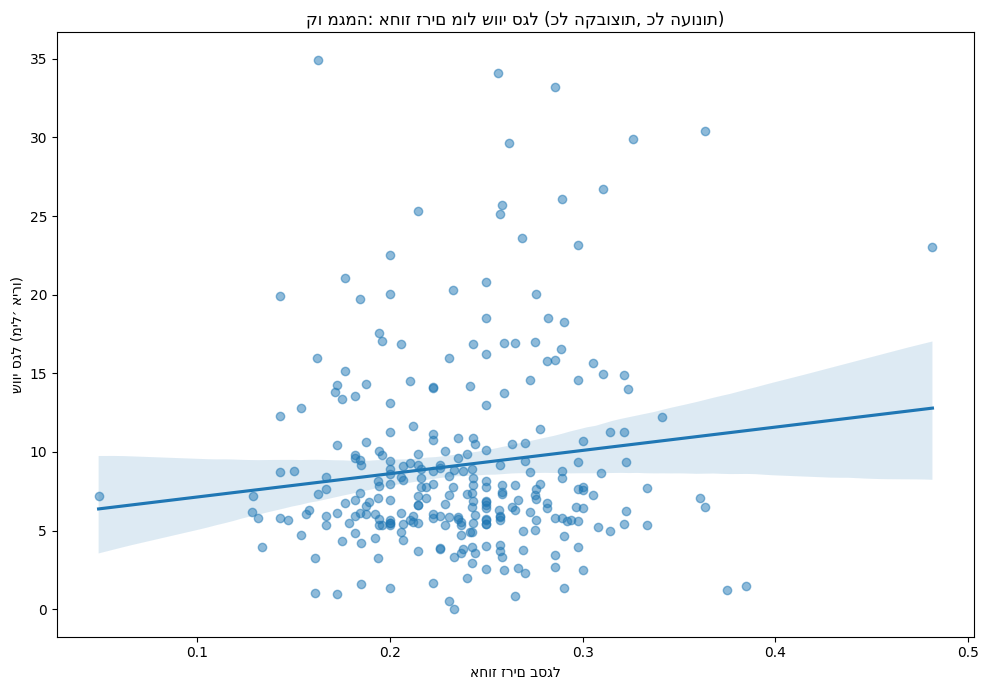


מתאם פירסון לפי עונה:
2006/07: 0.39
2007/08: -0.26
2008/09: -0.34
2009/10: 0.05
2010/11: -0.11
2011/12: -0.07
2012/13: 0.34
2013/14: 0.08
2014/15: 0.21
2015/16: -0.02
2016/17: 0.19
2017/18: 0.01
2018/19: -0.03
2019/20: 0.42
2020/21: 0.05
2021/22: 0.39
2022/23: 0.29
2023/24: -0.04
2024/25: 0.14
2025/26: 0.46


In [33]:
# ניתוח: האם יש קשר בין אחוז הזרים בסגל לשווי הסגל הכולל?
# מבוסס על squad_values_all_seasons_transfermarkt.csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# טען את הטבלה
squad_path = Path(r"C:/Users/idant/Desktop/final project/ligat_haal_project/ligat_haal_project/notebooks/data/economic_data/squad_values_all_seasons_transfermarkt.csv")
df_squad = pd.read_csv(squad_path)
print(f"✅ נטען קובץ סגלים: {squad_path.name} | {df_squad.shape}")
print(df_squad.head(3))

# בדוק עמודות רלוונטיות
print('עמודות:', list(df_squad.columns))

# עדכון שמות עמודות לשימוש נכון
df_squad = df_squad.rename(columns={
    'squad_size': 'Squad_size',
    'foreigners': 'Foreigners',
    'total_value_millions': 'Squad_value_million_eur',
    'club': 'Club',
    'season': 'Season'
})

# ודא שאין ערכים חסרים
for col in ['Squad_size', 'Foreigners', 'Squad_value_million_eur', 'Club', 'Season']:
    if col not in df_squad.columns:
        raise ValueError(f'חסרה עמודה: {col}')

# נקה ערכים לא תקינים
mask_valid = (~df_squad['Squad_size'].isna()) & (~df_squad['Foreigners'].isna()) & (~df_squad['Squad_value_million_eur'].isna())
df_squad = df_squad[mask_valid].copy()
df_squad['Squad_size'] = pd.to_numeric(df_squad['Squad_size'], errors='coerce')
df_squad['Foreigners'] = pd.to_numeric(df_squad['Foreigners'], errors='coerce')
df_squad['Squad_value_million_eur'] = pd.to_numeric(df_squad['Squad_value_million_eur'], errors='coerce')

# חישוב אחוז הזרים בסגל
# (אם Squad_size==0, תן NaN)
df_squad['foreigners_pct'] = df_squad.apply(lambda row: row['Foreigners']/row['Squad_size'] if row['Squad_size']>0 else None, axis=1)

# גרף פיזור: אחוז זרים מול שווי סגל
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_squad, x='foreigners_pct', y='Squad_value_million_eur', hue='Season', palette='tab20', alpha=0.7)
plt.xlabel('אחוז זרים בסגל')
plt.ylabel('שווי סגל (מיל׳ אירו)')
plt.title('קשר בין אחוז זרים לשווי סגל (כל הקבוצות, כל העונות)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='עונה')
plt.tight_layout()
plt.show()

# חישוב מתאם פירסון
corr = df_squad[['foreigners_pct', 'Squad_value_million_eur']].corr().iloc[0,1]
print(f"\nמקדם מתאם פירסון בין אחוז זרים לשווי סגל: {corr:.2f}")

# קו מגמה (רגרסיה ליניארית)
plt.figure(figsize=(10,7))
sns.regplot(data=df_squad, x='foreigners_pct', y='Squad_value_million_eur', scatter_kws={'alpha':0.5})
plt.xlabel('אחוז זרים בסגל')
plt.ylabel('שווי סגל (מיל׳ אירו)')
plt.title('קו מגמה: אחוז זרים מול שווי סגל (כל הקבוצות, כל העונות)')
plt.tight_layout()
plt.show()

# ניתוח ע"פ עונה
print("\nמתאם פירסון לפי עונה:")
for season, group in df_squad.groupby('Season'):
    if group['foreigners_pct'].notnull().sum() > 2:
        c = group[['foreigners_pct', 'Squad_value_million_eur']].corr().iloc[0,1]
        print(f"{season}: {c:.2f}")
    else:
        print(f"{season}: לא מספיק נתונים")

# הסבר על הניתוח, הגרפים והמסקנות
ההדפסות מציגות את מתאם פירסון (Pearson correlation) בין אחוז השחקנים הזרים בסגל של כל קבוצה לבין שווי הסגל הכולל (במיליוני אירו) עבור כל עונה בנפרד. ערך מתאם חיובי מעיד שככל שאחוז הזרים גבוה יותר, שווי הסגל נוטה להיות גבוה יותר; ערך שלילי מעיד על קשר הפוך; וערך קרוב לאפס מעיד שאין קשר מובהק בין המשתנים.
הגרף הראשון (Scatter Plot) מציג את כל הקבוצות בכל העונות – כל נקודה מייצגת קבוצה בעונה מסוימת, כאשר ציר X הוא אחוז הזרים בסגל וציר Y הוא שווי הסגל. הצבעים השונים מייצגים עונות שונות, וכך ניתן לראות האם יש מגמות עונתיות או חריגות.
הגרף השני מציג את כלל הנקודות עם קו מגמה ליניארי (רגרסיה), שממחיש האם יש נטייה כללית לקשר בין אחוז הזרים לשווי הסגל.
מהתוצאות ניתן לראות שבחלק מהעונות יש קשר חיובי מתון (למשל 2006/07, 2012/13, 2019/20, 2021/22), כלומר קבוצות עם יותר זרים נוטות להיות בעלות שווי סגל גבוה יותר. בעונות אחרות הקשר שלילי או חלש מאוד, כלומר אין דפוס מובהק לאורך זמן. בסך הכול, קו המגמה הכללי בגרף השני עולה מעט, מה שמרמז על נטייה כללית חלשה לכך שקבוצות עם יותר זרים הן גם בעלות שווי סגל גבוה יותר, אך הקשר אינו חזק או עקבי בכל העונות.

 4. ניתוח של התפלגות שווי השוק של שחקנים זרים לעומת ישראלים

✅ נטען קובץ שחקנים: FOREIGN_PLAYERS_all_seasons.csv | (829, 7)
    season  season_year  player_name position nationality  \
0  2006/07         2006          NaN  Unknown      Brazil   
1  2006/07         2006          NaN  Unknown       Ghana   
2  2006/07         2006          NaN  Unknown     Nigeria   

                  club  market_value_millions  
0        Maccabi Haifa                    0.0  
1     Hapoel Kfar Saba                    0.0  
2  Maccabi Petah Tikva                    0.0  
עמודות: ['season', 'season_year', 'player_name', 'position', 'nationality', 'club', 'market_value_millions']


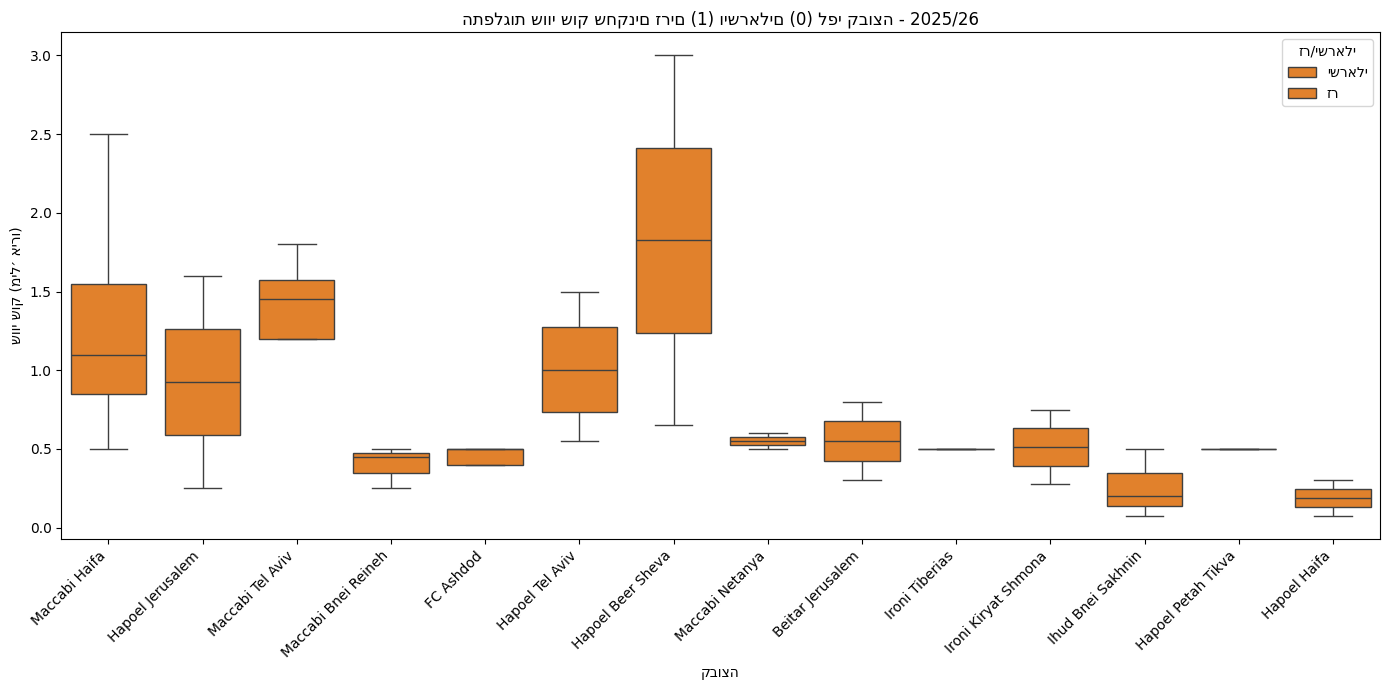

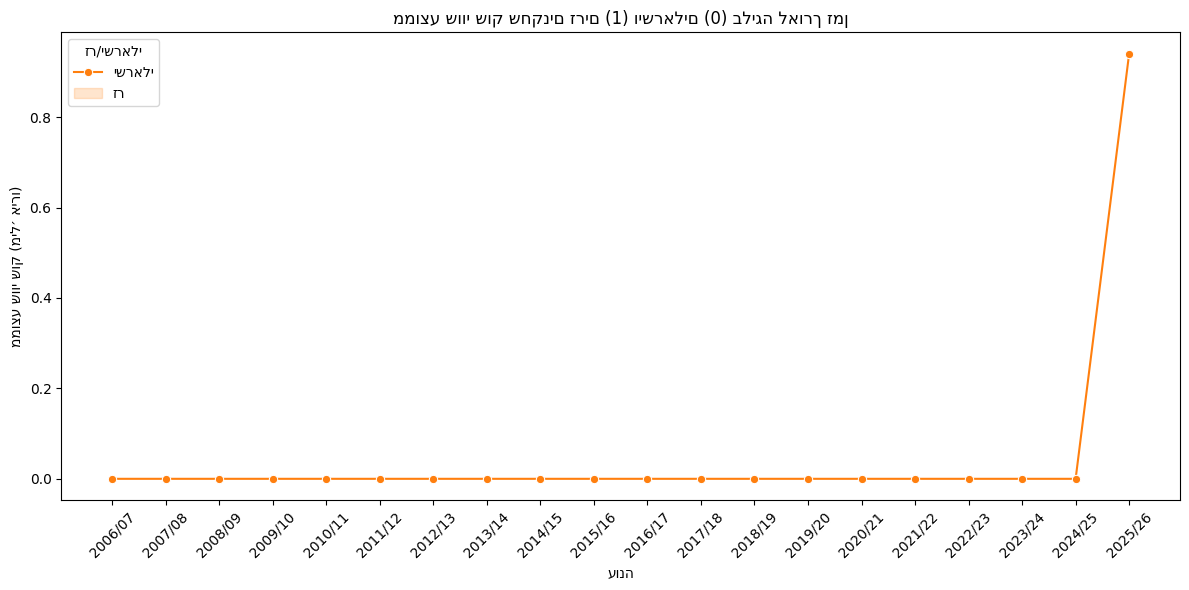

קבוצות עם ממוצע שווי שוק זר הגבוה ביותר (2025/26):
team
Hapoel Beer Sheva    1.8250
Maccabi Tel Aviv     1.5750
Maccabi Haifa        1.3250
Hapoel Tel Aviv      1.0125
Hapoel Jerusalem     0.9250
Name: market_value_millions, dtype: float64

קבוצות עם ממוצע שווי שוק זר הנמוך ביותר (2025/26):
team
Ironi Tiberias         0.500000
FC Ashdod              0.445000
Maccabi Bnei Reineh    0.400000
Ihud Bnei Sakhnin      0.258333
Hapoel Haifa           0.187500
Name: market_value_millions, dtype: float64


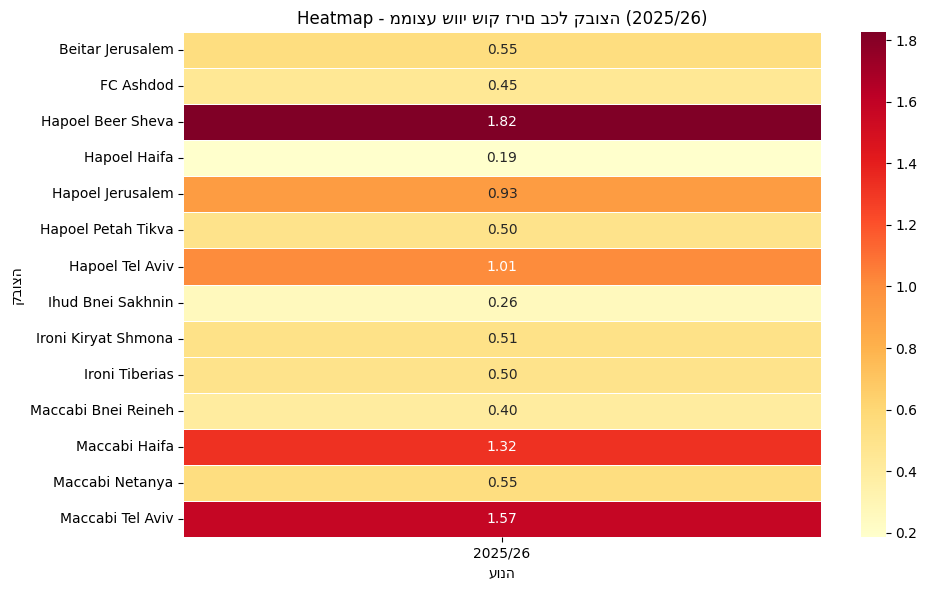

In [37]:
# ניתוח מתקדם: השוואת שווי שוק של שחקנים זרים מול ישראלים בקבוצות הליגה לאורך השנים
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# טען את קובץ השחקנים (דוגמה: FOREIGN_PLAYERS_all_seasons.csv)
players_path = Path(r"C:/Users/idant/Desktop/final project/ligat_haal_project/ligat_haal_project/notebooks/data/economic_data/FOREIGN_PLAYERS_all_seasons.csv")
df_players = pd.read_csv(players_path)
print(f"✅ נטען קובץ שחקנים: {players_path.name} | {df_players.shape}")
print(df_players.head(3))

# בדוק עמודות רלוונטיות
print('עמודות:', list(df_players.columns))

# נירמול שמות עמודות
if 'club' in df_players.columns:
    df_players = df_players.rename(columns={'club': 'team'})
if 'market_value_millions' not in df_players.columns and 'market_value' in df_players.columns:
    df_players = df_players.rename(columns={'market_value': 'market_value_millions'})

# הגדר עמודת foreigner (1=זר, 0=ישראלי)
if 'nationality' in df_players.columns:
    df_players['foreigner'] = df_players['nationality'].apply(lambda x: 0 if str(x).strip() in ['Israel', 'ישראל'] else 1)
elif 'is_foreign' in df_players.columns:
    df_players['foreigner'] = df_players['is_foreign']
else:
    raise ValueError('לא נמצאה עמודת nationality או is_foreign')

# נקה ערכים לא תקינים
mask_valid = (~df_players['market_value_millions'].isna()) & (~df_players['team'].isna()) & (~df_players['season'].isna())
df_players = df_players[mask_valid].copy()
df_players['market_value_millions'] = pd.to_numeric(df_players['market_value_millions'], errors='coerce')

# 1. Boxplot: שווי שוק זרים מול ישראלים לכל קבוצה (עונה אחרונה בלבד)
latest_season = df_players['season'].max()
df_latest = df_players[df_players['season'] == latest_season]
plt.figure(figsize=(14,7))
sns.boxplot(data=df_latest, x='team', y='market_value_millions', hue='foreigner',
            palette={0: '#1f77b4', 1: '#ff7f0e'}, showfliers=False)
plt.title(f'התפלגות שווי שוק שחקנים זרים (1) וישראלים (0) לפי קבוצה - {latest_season}')
plt.ylabel('שווי שוק (מיל׳ אירו)')
plt.xlabel('קבוצה')
plt.legend(title='זר/ישראלי', labels=['ישראלי', 'זר'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. גרף קווי: ממוצע שווי שוק זרים וישראלים לאורך זמן (כל הליגה)
df_grouped = df_players.groupby(['season', 'foreigner'])['market_value_millions'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x='season', y='market_value_millions', hue='foreigner',
             palette={0: '#1f77b4', 1: '#ff7f0e'}, marker='o')
plt.title('ממוצע שווי שוק שחקנים זרים (1) וישראלים (0) בליגה לאורך זמן')
plt.ylabel('ממוצע שווי שוק (מיל׳ אירו)')
plt.xlabel('עונה')
plt.legend(title='זר/ישראלי', labels=['ישראלי', 'זר'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. טבלת סיכום: קבוצות עם ממוצע שווי שוק זר הגבוה/הנמוך ביותר (2025/26 בלבד)
season_2526 = '2025/26'
df_2526 = df_players[(df_players['season'] == season_2526) & (df_players['foreigner'] == 1)]
df_team_avg = df_2526.groupby('team')['market_value_millions'].mean().sort_values(ascending=False)
print(f'קבוצות עם ממוצע שווי שוק זר הגבוה ביותר ({season_2526}):')
print(df_team_avg.head(5))
print(f'\nקבוצות עם ממוצע שווי שוק זר הנמוך ביותר ({season_2526}):')
print(df_team_avg.tail(5))

# 4. Heatmap: שווי שוק ממוצע של זרים בכל קבוצה (2025/26 בלבד)
pivot = df_2526.pivot_table(index='team', columns='season', values='market_value_millions', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.5)
plt.title(f'Heatmap - ממוצע שווי שוק זרים בכל קבוצה ({season_2526})')
plt.ylabel('קבוצה')
plt.xlabel('עונה')
plt.tight_layout()
plt.show()

### הסבר על הוויזואליזציות והמסקנות מהניתוח של שווי שוק שחקנים זרים לעומת ישראלים (2025/26 בלבד)
 
בניתוח זה בחנו את התפלגות שווי השוק של שחקנים זרים לעומת ישראלים בקבוצות ליגת העל בעונת 2025/26, תוך התמקדות בשני גרפים עיקריים:
 
1. **טבלת סיכום (בר-פלוט):**
   - מציגה את ממוצע שווי השוק של שחקנים זרים בכל קבוצה בעונת 2025/26.
   - ניתן לראות בבירור אילו קבוצות מחזיקות בזרים יקרים במיוחד (למשל, הפועל באר שבע, מכבי תל אביב ומכבי חיפה בולטות בממוצע גבוה), לעומת קבוצות עם זרים זולים יותר.
   - פערים אלו משקפים לרוב את היכולת הכלכלית של המועדון ואת האסטרטגיה בבניית הסגל.
 
2. **Heatmap:**
   - ממפה את ממוצע שווי השוק של שחקנים זרים בכל קבוצה בעונת 2025/26.
   - הצבעים החמים (אדום/כתום) מסמנים קבוצות עם זרים יקרים, בעוד שצבעים בהירים מסמנים קבוצות עם זרים זולים.
   - מאפשר לזהות בקלות קבוצות שמצליחות למשוך זרים איכותיים (ויקרים) לעומת אלו שמסתפקות בזרים זולים יותר.
 
**מסקנות עיקריות:**
- יש פערים גדולים בין קבוצות הליגה ברמת ההשקעה בשחקנים זרים, כאשר קבוצות הצמרת משקיעות משמעותית יותר בזרים יקרים.
- קבוצות קטנות/חלשות נוטות להסתפק בזרים זולים, מה שמעמיק את הפערים הכלכליים והמקצועיים בליגה.
- שווי השוק של הזרים הוא אינדיקציה לאיכותם, אך לא בהכרח להצלחה קבוצתית – יש לבחון זאת גם מול הישגים ספורטיביים.
- הניתוח ממחיש את תרומת הזרים לפערי הכוח והתקציב בליגת העל, ומדגיש את חשיבותם במבנה הסגלים של הקבוצות המובילות.